In [1]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Imports & Data preparation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
import glob
import os

from google.colab import drive
drive.mount('/content/drive')

# === Data pathes; PLEASE ADJUST base_path to run the code locally on your machine. ===

base_path = "/content/drive/MyDrive/SS25/MDS4AT/03_IndoorLocalisation/PhyphoxData/"

acc_files = [f"{base_path}acc{i}.csv" for i in range(1, 7)]
gyro_files = [f"{base_path}gyro{i}.csv" for i in range(1, 7)]

# === Load and Cut Data ===
def load_and_cut_data(acc_file, gyro_file, skip=1, start=10, end_margin=10):

    acc_df = pd.read_csv(acc_file, skiprows=skip)
    gyro_df = pd.read_csv(gyro_file, skiprows=skip)

    acc_time = acc_df.iloc[:, 0].values
    gyro_time = gyro_df.iloc[:, 0].values
    end_time = min(acc_time[-1], gyro_time[-1]) - end_margin

    acc_mask = (acc_time > start) & (acc_time < end_time)
    gyro_mask = (gyro_time > start) & (gyro_time < end_time)

    return {
        "acc_time": acc_time[acc_mask],
        "acc_xyz": acc_df.iloc[acc_mask, 1:4].values,
        "gyro_time": gyro_time[gyro_mask],
        "gyro_xyz": gyro_df.iloc[gyro_mask, 1:4].values
    }

Mounted at /content/drive


In [2]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Step detection using accelerometer data
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# === Function for smoothed z-score peak detection ===
def smoothed_z_score(y, lag=30, threshold=5.0, influence=0.0):

    signals = np.zeros(len(y))
    filtered_y = np.array(y)
    avg_filter = [0]*len(y)
    std_filter = [0]*len(y)
    avg_filter[lag - 1] = np.mean(y[0:lag])
    std_filter[lag - 1] = np.std(y[0:lag])

    for i in range(lag, len(y)):
        if abs(y[i] - avg_filter[i - 1]) > threshold * std_filter[i - 1]:
            if y[i] > avg_filter[i - 1]:
                signals[i] = 1  # Peak
            else:
                signals[i] = -1  # Do not use neg. peaks
            filtered_y[i] = influence * y[i] + (1 - influence) * filtered_y[i - 1]
        else:
            signals[i] = 0
            filtered_y[i] = y[i]

        avg_filter[i] = np.mean(filtered_y[(i - lag):i])
        std_filter[i] = np.std(filtered_y[(i - lag):i])

    return signals

# === Function for step detection ===
def detect_steps(acc_time, acc_xyz, filter_type="butter", detection_method="peaks", step_start_method="first"):

    acc_mag = np.linalg.norm(acc_xyz, axis=1)

    # --- Noise Removal ---
    if filter_type == "butter":  # Butterworth-Tiefpassfilter
        fs = 100
        cutoff = 3
        order = 4
        b, a = butter(order, cutoff / (0.5 * fs), btype='low')
        acc_filtered = filtfilt(b, a, acc_mag)

    elif filter_type == "moving_average":
        window_size = 30
        acc_filtered = np.convolve(acc_mag, np.ones(window_size)/window_size, mode='same')

    elif filter_type == "savgol":
        acc_filtered = savgol_filter(acc_mag, window_length=30, polyorder=3)

    else:
        raise ValueError(f"Unbekannter Filtertyp: {filter_type}")

    # --- Peak Detection ---
    if detection_method == "peaks":
        peaks, _ = find_peaks(acc_filtered, distance=20, prominence=0.3)

    elif detection_method == "zscore":
        zscore_signal = smoothed_z_score(acc_filtered, lag=30, threshold=3.5, influence=0.5)
        peaks = np.where(zscore_signal == 1)[0]

    else:
        raise ValueError(f"Unbekannte Erkennungsmethode: {detection_method}")

    step_times = acc_time[peaks]

    # --- Step start estimation ---
    if step_start_method == "first":
        step_start_time = step_times[0] if len(step_times) > 0 else None

    elif step_start_method == "mean2":
        step_start_time = np.mean(step_times[:2]) if len(step_times) >= 2 else None

    elif step_start_method == "valley":
        if len(peaks) >= 2:
            i1, i2 = peaks[0], peaks[1]
            min_idx = i1 + np.argmin(acc_filtered[i1:i2])
            step_start_time = acc_time[min_idx]
        else:
            step_start_time = None

    else:
        raise ValueError(f"Unbekannte Methode für step_start: {step_start_method}")

    return step_times, step_start_time, acc_mag, acc_filtered, peaks

In [3]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Angular integration using gyroscope data
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# === Function for computing rotation matrix ===
def compute_rotation_matrices(acc_data, mu=0.9):

    g_prev = acc_data[0]
    R_list = []

    for a in acc_data:
        g_t = mu * g_prev + (1 - mu) * a
        g_prev = g_t
        uz = g_t / np.linalg.norm(g_t)
        ux = np.cross([0, 1, 0], uz)
        ux /= np.linalg.norm(ux)
        uy = np.cross(uz, ux)
        R_list.append(np.column_stack((ux, uy, uz)))

    return np.array(R_list)

# === Function for turning angle estimation by integrating projected turn rate ===
def integrate_angle(gyro_time, omega_z):

    dt = np.diff(gyro_time)
    omega_mid = omega_z[:-1]
    theta_rad = np.cumsum(omega_mid * dt)

    return gyro_time[1:], theta_rad

In [12]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Plotting estimated tracks
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# === Function for estimating track ===
def compute_path(step_times, theta_time, theta_rad, step_length=0.75):

    theta_interp = np.interp(step_times, theta_time, theta_rad)
    x, y = 0.0, 0.0
    x_list, y_list = [x], [y]
    for theta in theta_interp:
        x += step_length * np.cos(theta)
        y += step_length * np.sin(theta)
        x_list.append(x)
        y_list.append(y)

    return x_list, y_list

# === Function for processing a pair of acc- and gyro-data and plotting track; PLEASE ADJUST for different filter, detection - and step start methods ===
def process_pair(acc_file, gyro_file, mu=0.9, step_length=0.75, plot=True, filter_type="butter", detection_method="peaks", step_start_method="first"):

    data = load_and_cut_data(acc_file, gyro_file)

    # Rotation & world-coordinates
    acc_interp = np.array([np.interp(data["gyro_time"], data["acc_time"], data["acc_xyz"][:, i]) for i in range(3)]).T
    R = compute_rotation_matrices(acc_interp, mu)
    omega_world = np.einsum('ijk,ik->ij', np.transpose(R, (0, 2, 1)), data["gyro_xyz"])
    omega_z = omega_world[:, 2]

    # Angle integration
    theta_time, theta_rad = integrate_angle(data["gyro_time"], omega_z)
    theta_deg = np.degrees(theta_rad)

    # Step detection
    step_times, step_start_time, acc_mag, acc_smooth, peaks = detect_steps(data["acc_time"], data["acc_xyz"], filter_type=filter_type, detection_method=detection_method, step_start_method=step_start_method)

    # Track estimation
    x_list, y_list = compute_path(step_times, theta_time, theta_rad, step_length)

    # --- Plot: Steps ---
    if plot:
        # Plot Magnitude & Schritte
        plt.figure(figsize=(10, 4))
        plt.plot(data["acc_time"], acc_mag, label="Original")
        plt.plot(data["acc_time"], acc_smooth, label="Geglättet", linewidth=2)
        plt.plot(step_times, acc_smooth[peaks], 'rx', label="Erkannte Schritte")
        plt.xlabel("Zeit (s)")
        plt.ylabel("Beschleunigung (m/s²)")
        plt.title(f"Schritterkennung: {os.path.basename(acc_file)}")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        # Plot turning angle Θ(t)
        plt.figure(figsize=(10, 4))
        plt.plot(theta_time, theta_deg, label="Drehwinkel Θ(t) [°]")
        plt.xlabel("Zeit (s)")
        plt.ylabel("Winkel (Grad)")
        plt.title(f"Drehwinkelverlauf: {os.path.basename(acc_file)}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot track with step marks
        plt.figure(figsize=(6, 6))
        plt.plot(x_list, y_list, linestyle='-', marker='o')
        for i, (x, y) in enumerate(zip(x_list, y_list)):
            plt.text(x, y, str(i), fontsize=8, ha='center', va='center')
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.title(f"Geschätzter Pfad: {os.path.basename(acc_file)}")
        plt.axis("equal")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "acc_file": acc_file,
        "gyro_file": gyro_file,
        "step_times": step_times,
        "step_start_time": step_start_time,
        "theta_time": theta_time,
        "theta_rad": theta_rad,
        "theta_deg": theta_deg,
        "path_x": x_list,
        "path_y": y_list
    }


--- Verarbeitung: acc1.csv + gyro1.csv ---


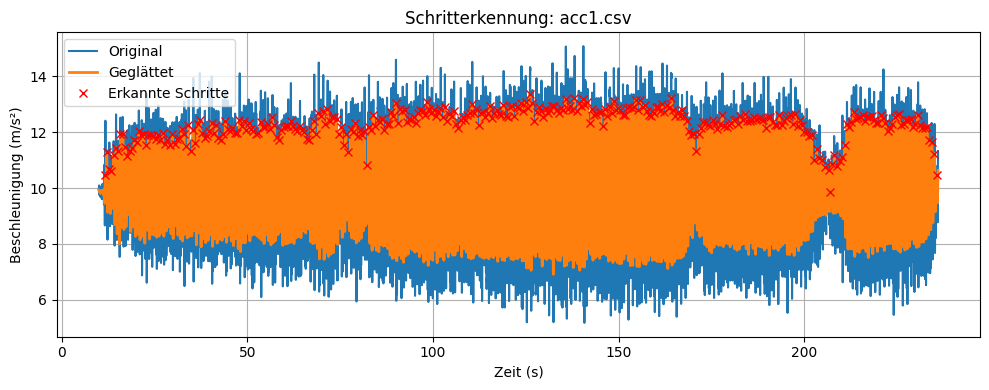

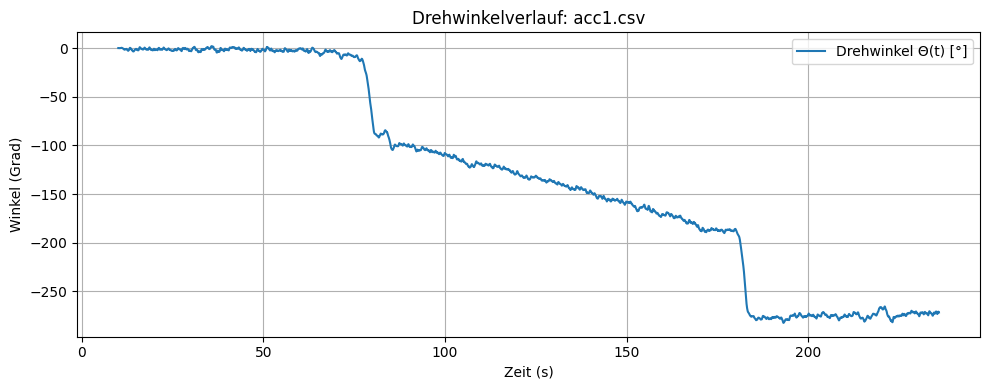

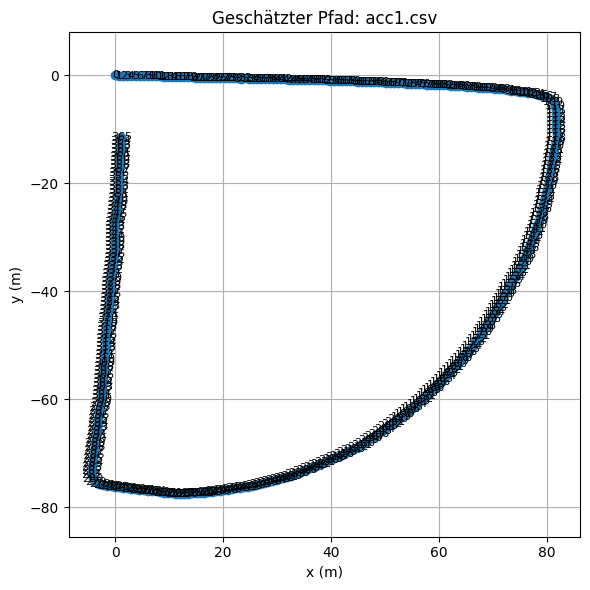

  Schritte erkannt: 365
  Erster Schrittstart bei: 11.75 s

--- Verarbeitung: acc2.csv + gyro2.csv ---


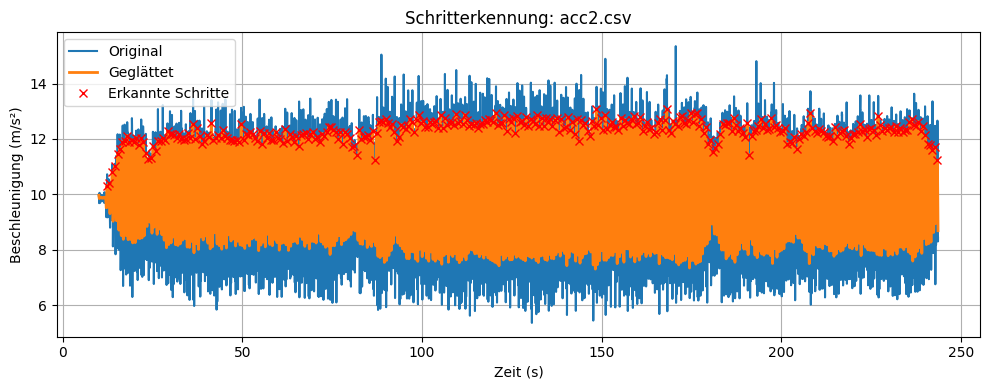

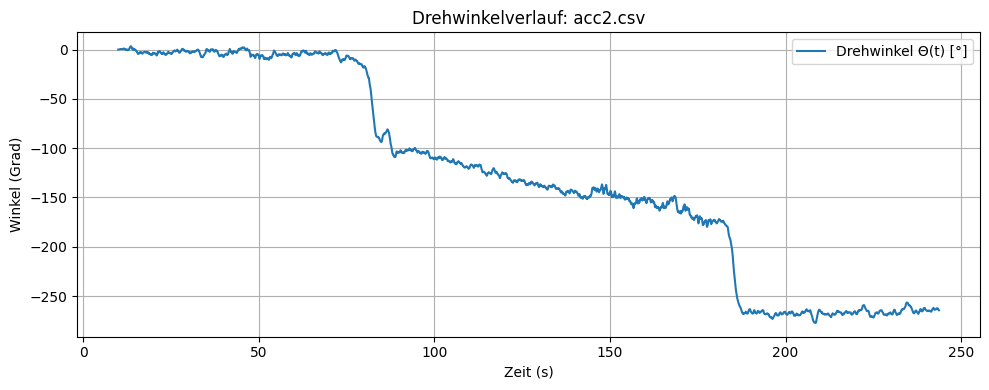

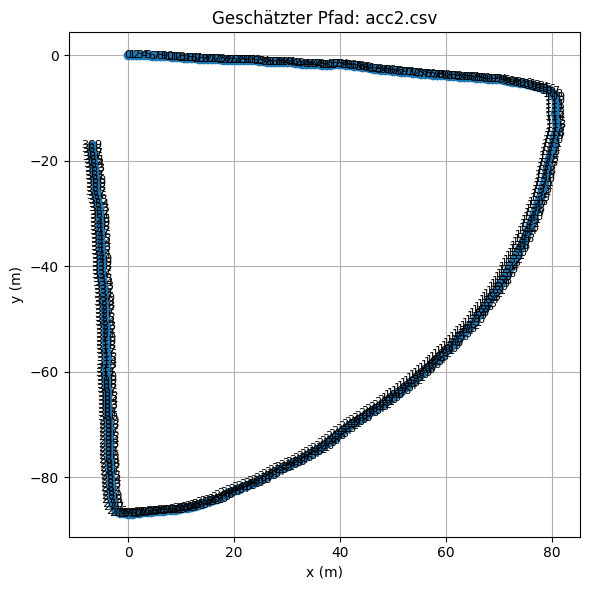

  Schritte erkannt: 369
  Erster Schrittstart bei: 12.28 s

--- Verarbeitung: acc3.csv + gyro3.csv ---


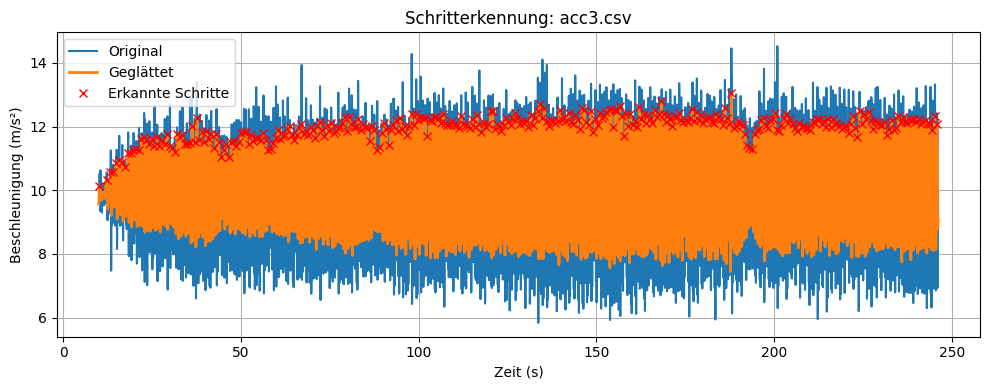

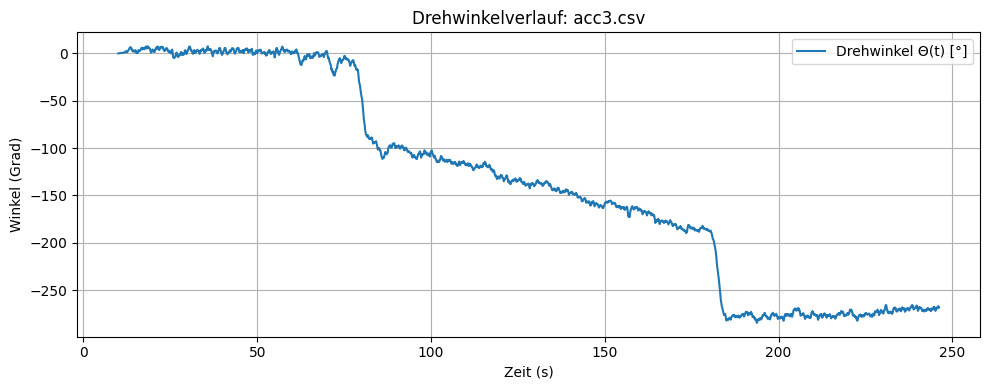

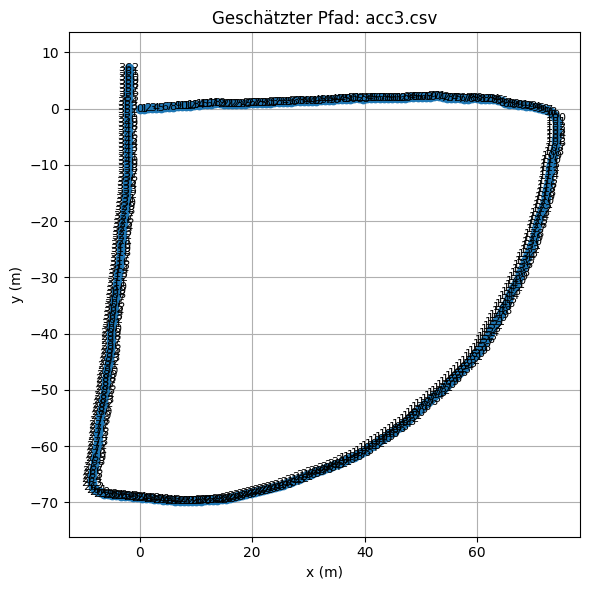

  Schritte erkannt: 362
  Erster Schrittstart bei: 10.17 s

--- Verarbeitung: acc4.csv + gyro4.csv ---


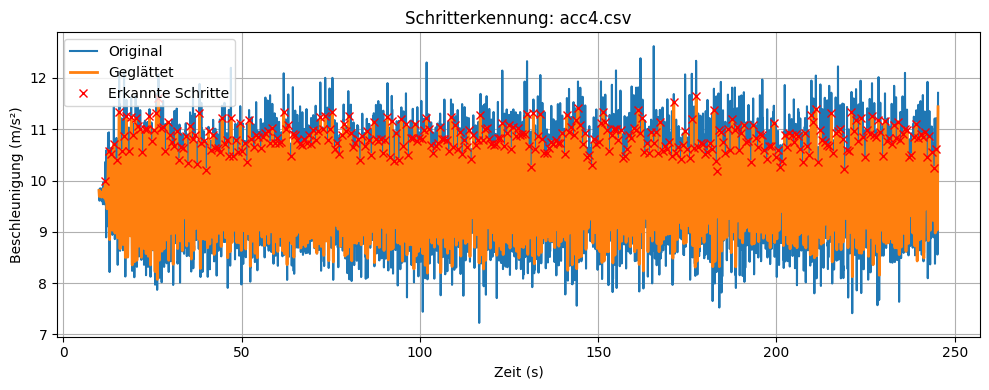

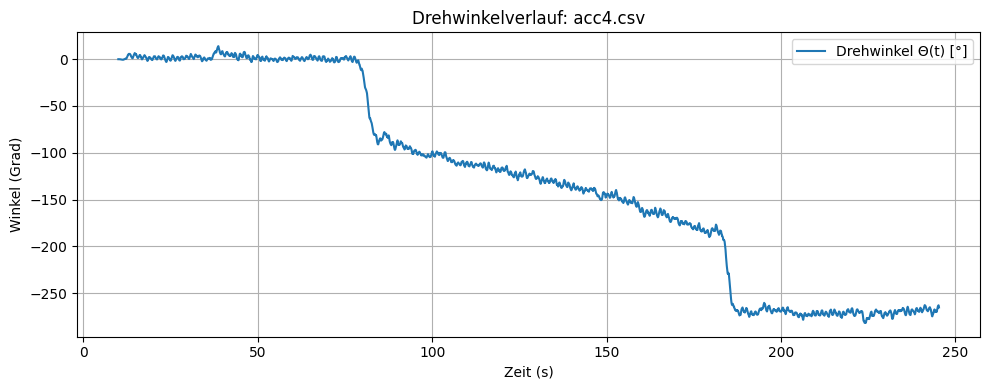

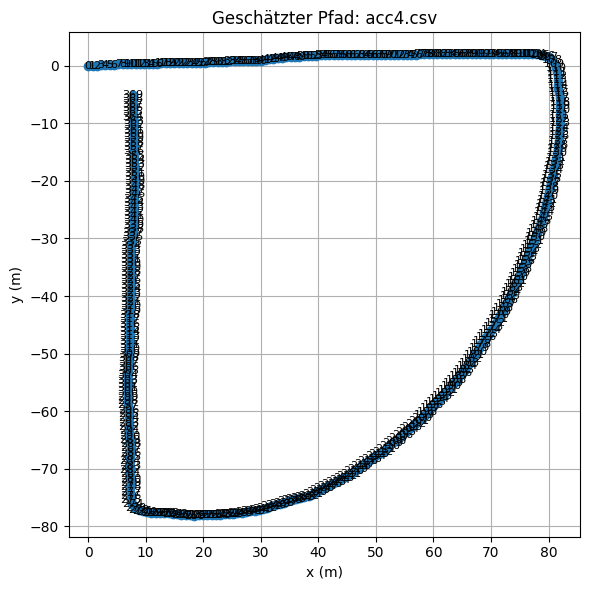

  Schritte erkannt: 369
  Erster Schrittstart bei: 11.80 s

--- Verarbeitung: acc5.csv + gyro5.csv ---


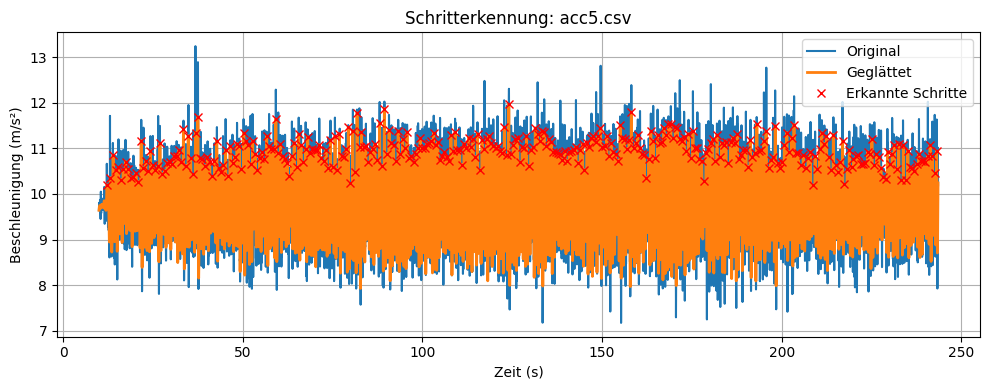

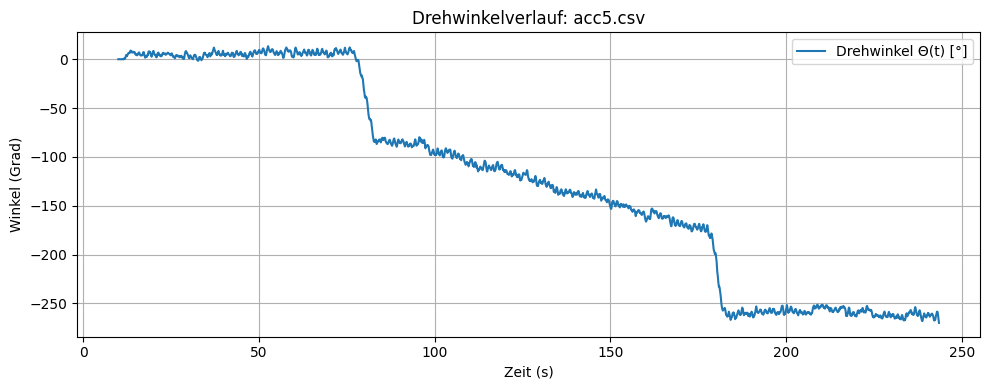

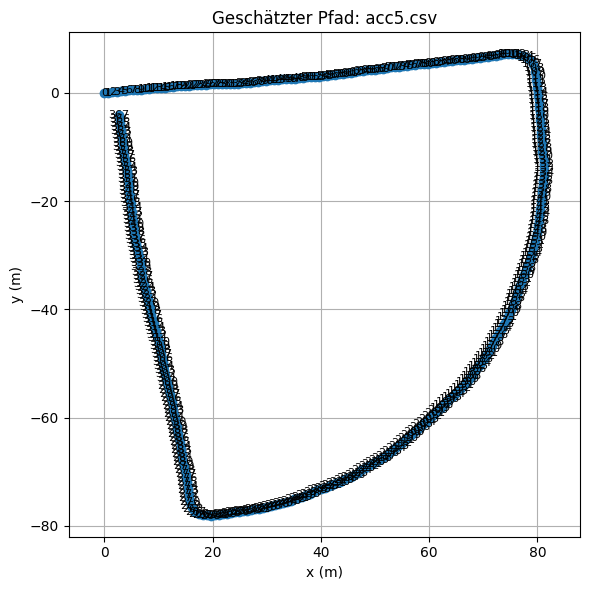

  Schritte erkannt: 367
  Erster Schrittstart bei: 12.24 s

--- Verarbeitung: acc6.csv + gyro6.csv ---


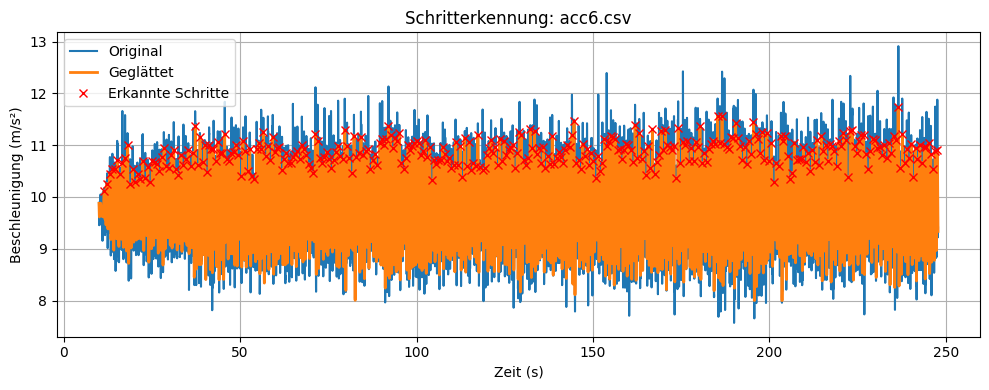

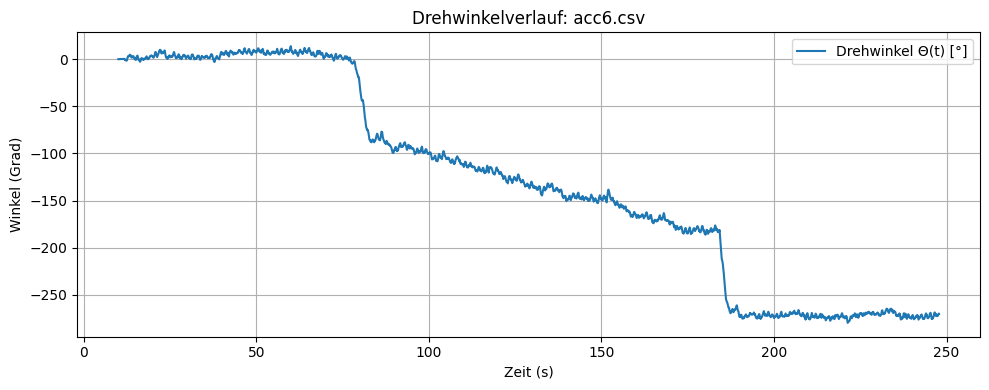

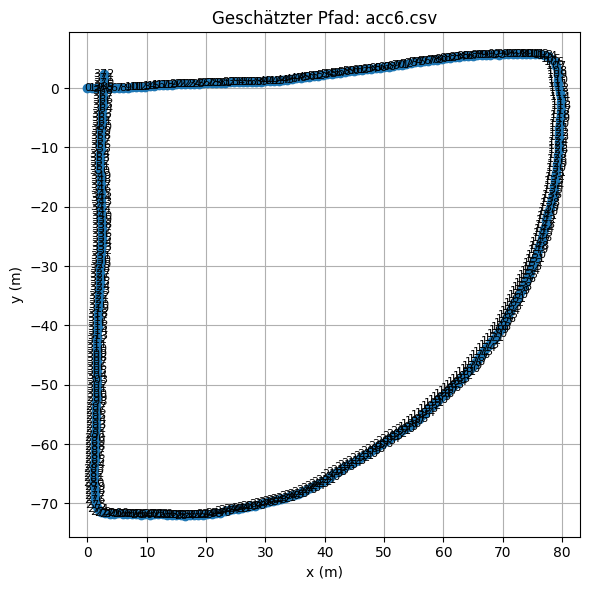

  Schritte erkannt: 372
  Erster Schrittstart bei: 11.46 s


In [13]:
# === Main ===
results_all = []
for acc_file, gyro_file in zip(acc_files, gyro_files):
    print(f"\n--- Verarbeitung: {os.path.basename(acc_file)} + {os.path.basename(gyro_file)} ---")
    result = process_pair(acc_file, gyro_file)
    print(f"  Schritte erkannt: {len(result['step_times'])}")
    if result["step_start_time"]:
        print(f"  Erster Schrittstart bei: {result['step_start_time']:.2f} s")
    else:
        print("  Kein Schritt erkannt.")
    results_all.append(result)